In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import textblob as tb

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

## ML Imports #
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peterclark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/peterclark/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/peterclark/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:

STOPWORDS = set(stopwords.words('english'))
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in STOPWORDS]

    return ' '.join(tokens)

def split_ticket(ticket):
        try:
            parts = str(ticket).split('/')
            # Returns (TicketType, TicketClass)
            # Example: 'CB/734/XL' -> 'CB', 'XL'
            return parts[0], int(parts[1]), parts[2]
        except:
            return None, None, None

def split_id(id):
    try:
        parts = str(id).split('/')
        return parts[0], parts[1]
    except:
        return 0,0

sia=SentimentIntensityAnalyzer()
def vader_polarity(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    return sia.polarity_scores(text)["compound"]


def preprocess_csv_cat(path, save=False, filename=""):
    # 1. Load data
    data = pd.read_csv(path)

    # 2. Fill missing Age and create isAdult
    data["Age"] = data["Age"].fillna(data["Age"].median())
    #data['Age'] = data['Age'].fillna(-1)
    data["isAdult"] = data["Age"] >= 18

    # 3. Create consumption flags and log features
    data["consumeF"] = data["Food"] > 0.0
    data["consumeD"] = data["Drinks"] > 0.0
    data["logDrinks"] = np.log1p(data["Drinks"])
    data["logFood"] = np.log1p(data["Food"])
    
    data['id1_col'], data['id2_col'] = zip(*data["Id"].apply(split_id))

    # 4. Compute Opinion polarity
    data["Opinion_Polarity"] = data["Opinion"].apply(preprocess_text).apply(vader_polarity)

    # 2. Bin into 5 Groups (Stars 1-5)
    # Polarity ranges from -1.0 to 1.0. We slice this into 5 bins.
    # Bins: [-1, -0.6, -0.2, 0.2, 0.6, 1.0]
    #star_labels = ['1_Star', '2_Star', '3_Star', '4_Star', '5_Star']
    #data['Opinion_Stars'] = pd.cut(data["Opinion_Polarity"], bins=5, labels=star_labels)

    # If you only want 3 groups as you hinted initially:
    #star_labels_3 = ['Negative', 'Neutral', 'Positive']
    #data['Opinion_Stars'] = pd.cut(data["Opinion_Polarity"], bins=3, labels=star_labels_3)

   
    # --- Concert-specific handling ---
    # 6. Fill missing Concert values
    def fill_concert(row):
        if pd.notna(row["Concert"]):
            return row["Concert"]
        
        for _,city in enumerate(["NYC", "SF", "FL"]):
            if city in str(row["Opinion"]):
                t_concert=["12_5PM","14_7PM","16-7PM"]
                return city+t_concert[_]
        # If no info, fill with mode
        return data["Concert"].mode()[0]

    data["Concert"] = data.apply(fill_concert, axis=1)

    # 7. Extract Concert info
    data["Concert_City"] = data["Concert"].astype(str).str.extract(r"^([A-Za-z]+)")

    

    # Drop intermediate columns
    data = data.drop(columns=["Concert"])

    ticket_letters = ['A', 'B', 'CB', 'CB','LB','LT','RT', 'PB','RB']
    ticket_letters_p = [0.092626,0.108936,0.293495,0.003658, 0.328885, 0.087683, 0.004053, 0.026196, 0.054468]
    ticket_classes = ['N', 'XL']  # adjust based on your data

    # Function to create a random ticket
    def generate_ticket():
        letter = np.random.choice(ticket_letters,p=ticket_letters_p)
        number = f"{np.random.randint(0, 9999):04d}"  # four-digit with leading zeros
        tclass = np.random.choice(ticket_classes,p=[0.50,0.50])
        return f"{letter}/{number}/{tclass}"
    def fill_ticket(row):
        if pd.notna(row["TicketInfo"]):
            return row["TicketInfo"]
        # Generate a ticket if missing
        return generate_ticket()

    data["TicketInfo"] = data.apply(fill_ticket, axis=1)

    # 9. Split TicketInfo into separate columns
    data[["Ticket_Type", "Ticket_Num", "Ticket_Class"]] = data["TicketInfo"].apply(
        lambda x: pd.Series(split_ticket(x))
    )

    # 10. Encode categorical columns
    categorical_cols = [
        "PreferedAlbum", "Vinyl", "VIP", "Concert_City", "Ticket_Type", "Ticket_Class"
    ]
    
    
    # 5. Fill missing categorical columns
    cat_cols = ['PreferedAlbum', 'Vinyl', 'VIP']
    for col in cat_cols:
        #data[col] = data[col].fillna('Missing')
        data[col]=data[col].fillna(data[col].mode()[0])  
    
    
    categorical_features = []
    for col in categorical_cols:
        if col in data.columns:
            data[col] = data[col].astype("category").cat.codes
            categorical_features.append(col)


    df_final = data.drop(columns=["Opinion", "TicketInfo"])

    cat_feature_idx = [
        df_final.columns.get_loc(c)
        for c in categorical_features
        if c in df_final.columns
    ]

    
    if save:
        df_final.to_csv(filename, index=False)

    return df_final, cat_feature_idx


In [5]:
def remove_and_split(data_cat,data_cat_idx,data_test_cat, cols_to_drop, randstate):
    # Prepare training data -> split training set into (70% / 15% / 15%) #
    X_cat=data_cat.drop(columns=cols_to_drop)
    IDs_cat=data_cat["Id"]
    categorical_cols = [
    "PreferedAlbum",
    "Vinyl",
    "VIP",
    "Concert_City",
    "Ticket_Type",
    "Ticket_Class",
    "isAdult",
    'id1_col',
    #"Opinion_Stars",
    #"consumeF",
    #"consumeD"
]
    
    data_cat_idx = [
    X_cat.columns.get_loc(c)
    for c in categorical_cols
    if c in X_cat.columns
]
    
    Y_cat=data_cat["FreePass"]
    IDs=data_cat["Id"]
    
    cols_to_drop_test=cols_to_drop.copy()
    cols_to_drop_test.remove('FreePass')  # Keep FreePass in test set for prediction
    
    data_test_IDs = data_test_cat["Id"]
    X_test_ext = data_test_cat.drop(columns=cols_to_drop_test)
    
    # 100 -> 70/30 #
    X_train_cat, X_test_cat, Y_train_cat, Y_test_cat, ID_train_cat, ID_test_cat = train_test_split(
        X_cat,Y_cat,IDs_cat,
        test_size=0.3,
        random_state=randstate,
        stratify=Y_cat
    )
    
    return X_train_cat, X_test_cat, Y_train_cat, Y_test_cat, ID_train_cat, ID_test_cat, X_test_ext, data_test_IDs, data_cat_idx,IDs

In [6]:

# DEFINE MODELS & TRAIN/EVAL

def train_model(model, x_train, y_train, sample_weight=None):
    model.fit(x_train, y_train, sample_weight=sample_weight)
    return model


def eval_model(model, x, y=None, threshold=0.5):
    score = model.predict_proba(x)[:,1]
    output = score >= threshold
    metrics=[]
    if y is not None:
        metrics.append(roc_auc_score(y,score))
        metrics.append(np.sum(y==output)/(len(y)))
        metrics.append(log_loss(y, score))
        metrics.append(f1_score(y, output))
    return score, output, metrics

PROCESSING DATA

In [83]:

path = os.getcwd()
data_cat, data_cat_idx=preprocess_csv_cat(path+'/train.csv', save=False, filename=path+'/train_cleaned.csv')
data_cat.columns
data_test_cat, data_test_cat_idx=preprocess_csv_cat(path+'/test.csv', save=False, filename=path+'/test_cleaned.csv')
data_test_cat.head()
data_cat.columns


Index(['Id', 'PreferedAlbum', 'Vinyl', 'AvgTime', 'Age', 'VIP', 'Food',
       'Drinks', 'FreePass', 'isAdult', 'consumeF', 'consumeD', 'logDrinks',
       'logFood', 'id1_col', 'id2_col', 'Opinion_Polarity', 'Concert_City',
       'Ticket_Type', 'Ticket_Num', 'Ticket_Class'],
      dtype='object')

In [23]:
SPLIT = 2.0

tmin, tmax = data_test_cat['AvgTime'].min(), data_test_cat['AvgTime'].max()

low = data_cat['AvgTime'] < SPLIT
high = ~low

lmin, lmax = data_cat.loc[low, 'AvgTime'].min(), data_cat.loc[low, 'AvgTime'].max()
hmin, hmax = data_cat.loc[high, 'AvgTime'].min(), data_cat.loc[high, 'AvgTime'].max()

data_cat['AvgTimeNorm'] = np.nan
data_cat.loc[low, 'AvgTimeNorm'] = (
    (data_cat.loc[low, 'AvgTime'] - lmin) / (lmax - lmin)
) * (tmax - tmin) + tmin

data_cat.loc[high, 'AvgTimeNorm'] = (
    (data_cat.loc[high, 'AvgTime'] - hmin) / (hmax - hmin)
) * (tmax - tmin) + tmin

data_cat.AvgTime = data_cat.AvgTimeNorm

In [84]:
data_cat.columns

Index(['Id', 'PreferedAlbum', 'Vinyl', 'AvgTime', 'Age', 'VIP', 'Food',
       'Drinks', 'FreePass', 'isAdult', 'consumeF', 'consumeD', 'logDrinks',
       'logFood', 'id1_col', 'id2_col', 'Opinion_Polarity', 'Concert_City',
       'Ticket_Type', 'Ticket_Num', 'Ticket_Class'],
      dtype='object')

In [96]:
data_test_cat.columns

Index(['Id', 'PreferedAlbum', 'Vinyl', 'AvgTime', 'Age', 'VIP', 'Food',
       'Drinks', 'isAdult', 'consumeF', 'consumeD', 'logDrinks', 'logFood',
       'id1_col', 'id2_col', 'Opinion_Polarity', 'Concert_City', 'Ticket_Type',
       'Ticket_Num', 'Ticket_Class'],
      dtype='object')

In [85]:
data_cat['AvgTime2']=data_cat.apply(
    lambda x: x['AvgTime']*2.1+0.9 if x['FreePass'] == False else x['AvgTime']*(1.7/2)-1.2, axis=1
)
data_cat=data_cat.drop(columns='AvgTime')
data_cat['AvgTime']=data_cat['AvgTime2']
data_cat=data_cat.drop(columns='AvgTime2')

In [86]:
data_cat.columns

Index(['Id', 'PreferedAlbum', 'Vinyl', 'Age', 'VIP', 'Food', 'Drinks',
       'FreePass', 'isAdult', 'consumeF', 'consumeD', 'logDrinks', 'logFood',
       'id1_col', 'id2_col', 'Opinion_Polarity', 'Concert_City', 'Ticket_Type',
       'Ticket_Num', 'Ticket_Class', 'AvgTime'],
      dtype='object')

In [ ]:

cols_to_drop=["Id","FreePass", 'VIP', 
              'consumeD', 'Drinks', 'Food', 'consumeF', 'isAdult','id2_col']

randstate=np.random.randint(0,1000)
X_train_cat, X_test_cat, Y_train_cat, Y_test_cat, ID_train_cat, ID_test_cat, X_test_ext, data_test_IDs, data_cat_idx,IDs = remove_and_split(data_cat,data_cat_idx,data_test_cat, cols_to_drop, randstate)

In [103]:
data_test_IDs = data_test_cat["Id"]

cols_to_drop_test=["Id", 'VIP', 
              'consumeD', 'Drinks', 'Food', 'consumeF', 'isAdult','id2_col']
X_test_ext = data_test_cat.drop(columns=cols_to_drop_test)
X_test_ext=X_test_ext[['PreferedAlbum', 'Vinyl', 'Age', 'logDrinks', 'logFood', 'id1_col',
       'Opinion_Polarity', 'Concert_City', 'Ticket_Type', 'Ticket_Num',
       'Ticket_Class', 'AvgTime']]

In [88]:
X_train_cat.columns

Index(['PreferedAlbum', 'Vinyl', 'Age', 'logDrinks', 'logFood', 'id1_col',
       'Opinion_Polarity', 'Concert_City', 'Ticket_Type', 'Ticket_Num',
       'Ticket_Class', 'AvgTime'],
      dtype='object')

In [89]:
X_train_cat.head()

,PreferedAlbum,Vinyl,Age,logDrinks,logFood,id1_col,Opinion_Polarity,Concert_City,Ticket_Type,Ticket_Num,Ticket_Class,AvgTime
3156,1,0,30.0,2.397895,6.683361,01,-0.6808,1,2,750,1,0.80175
7625,1,1,40.0,0.000000,0.000000,01,0.5106,0,2,106,1,1.53955
1189,2,0,18.0,10.261197,7.538495,01,0.0000,1,0,280,0,2.87820
6968,2,1,39.0,0.000000,0.000000,02,-0.1058,1,5,230,1,1.99685
3897,2,1,33.0,0.000000,0.000000,02,0.0000,1,4,323,1,1.70870


Opinion strategies

Freepass strategies

<Axes: xlabel='AvgTime', ylabel='Count'>

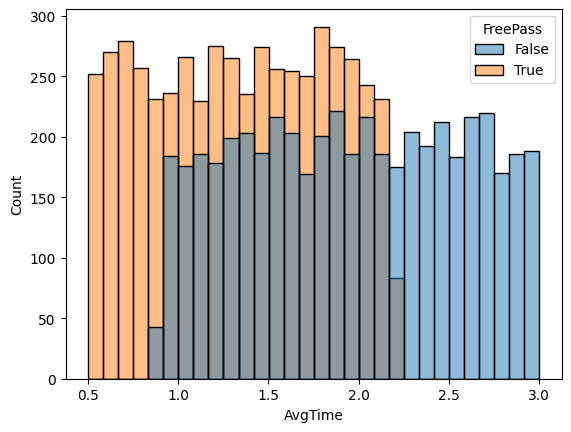

In [91]:
sns.histplot(data=data_cat,x='AvgTime', hue='FreePass')
#sns.histplot(data=data_test_cat,x='AvgTime',legend='test_distribution')

<Axes: xlabel='id1_col', ylabel='Count'>

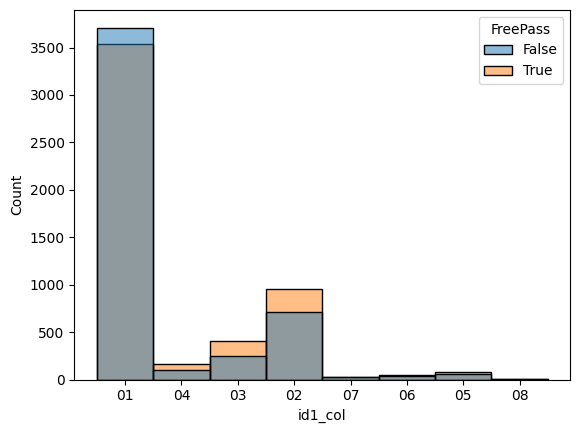

In [13]:
sns.histplot(data=data_cat,x='id1_col', hue='FreePass')


In [92]:
from sklearn.model_selection import StratifiedKFold

learning_rates = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1]
depths = [3, 4, 5, 6]
thresholds = np.linspace(0.3, 0.7, 40)

# Track best overall
best_lr = None
best_depth = None
best_threshold = 0.5
best_score = 0
best_acc = 0

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Starting hyperparameter search with 5-fold CV...\n")

results = []

for lr in learning_rates:
    for d in depths:
        # Store CV scores for this hyperparameter combo
        cv_f1_scores = []
        cv_acc_scores = []
        cv_best_thresholds = []
        
        for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_cat, Y_train_cat)):
            # Split data for this fold
            X_train_fold = X_train_cat.iloc[train_idx]
            X_val_fold = X_train_cat.iloc[val_idx]
            Y_train_fold = Y_train_cat.iloc[train_idx]
            Y_val_fold = Y_train_cat.iloc[val_idx]
            
            # Train model
            model = HistGradientBoostingClassifier(
                max_iter=500,
                early_stopping=False,  # Can't use early stopping with CV
                loss='log_loss',
                learning_rate=lr,
                max_depth=d,
                random_state=42,
                categorical_features=data_cat_idx
            )
            model.fit(X_train_fold, Y_train_fold)
            
            # Find best threshold for this fold
            fold_best_f1 = 0
            fold_best_threshold = 0.5
            fold_best_acc = 0
            
            for t in thresholds:
                proba = model.predict_proba(X_val_fold)[:, 1]
                pred = proba >= t
                f1 = f1_score(Y_val_fold, pred)
                
                if f1 > fold_best_f1:
                    fold_best_f1 = f1
                    fold_best_threshold = t
                    fold_best_acc = np.mean(Y_val_fold == pred)
            
            cv_f1_scores.append(fold_best_f1)
            cv_acc_scores.append(fold_best_acc)
            cv_best_thresholds.append(fold_best_threshold)
        
        # Average across folds
        mean_f1 = np.mean(cv_f1_scores)
        std_f1 = np.std(cv_f1_scores)
        mean_acc = np.mean(cv_acc_scores)
        mean_threshold = np.mean(cv_best_thresholds)
        
        results.append({
            'lr': lr,
            'depth': d,
            'mean_f1': mean_f1,
            'std_f1': std_f1,
            'mean_acc': mean_acc,
            'mean_threshold': mean_threshold
        })
        
        print(f"lr={lr:.3f}, depth={d}: F1={mean_f1:.4f} (+/-{std_f1:.4f}), Acc={mean_acc:.4f}, Threshold={mean_threshold:.3f}")
        
        # Update global best
        if mean_f1 > best_score:
            best_score = mean_f1
            best_lr = lr
            best_depth = d
            best_threshold = mean_threshold
            best_acc = mean_acc

# Print best configuration
print(f"\n{'='*60}")
print(f"BEST MODEL FOUND (via 5-fold CV):")
print(f"Learning Rate: {best_lr}")
print(f"Max Depth: {best_depth}")
print(f"Best Threshold: {best_threshold:.3f}")
print(f"CV F1 Score: {best_score:.4f}")
print(f"CV Accuracy: {best_acc:.4f}")
print(f"{'='*60}\n")

# Show top 5 configurations
results_df = pd.DataFrame(results).sort_values('mean_f1', ascending=False)
print("Top 5 configurations:")
print(results_df.head().to_string(index=False))

Starting hyperparameter search with 5-fold CV...

lr=0.010, depth=3: F1=0.8767 (+/-0.0052), Acc=0.8706, Threshold=0.460
lr=0.010, depth=4: F1=0.8803 (+/-0.0039), Acc=0.8720, Threshold=0.433
lr=0.010, depth=5: F1=0.8820 (+/-0.0032), Acc=0.8766, Threshold=0.462
lr=0.010, depth=6: F1=0.8840 (+/-0.0041), Acc=0.8793, Threshold=0.464
lr=0.020, depth=3: F1=0.8836 (+/-0.0031), Acc=0.8774, Threshold=0.446
lr=0.020, depth=4: F1=0.8859 (+/-0.0020), Acc=0.8785, Threshold=0.421
lr=0.020, depth=5: F1=0.8862 (+/-0.0020), Acc=0.8783, Threshold=0.407
lr=0.020, depth=6: F1=0.8863 (+/-0.0032), Acc=0.8797, Threshold=0.423
lr=0.030, depth=3: F1=0.8862 (+/-0.0023), Acc=0.8801, Threshold=0.437
lr=0.030, depth=4: F1=0.8880 (+/-0.0031), Acc=0.8812, Threshold=0.421
lr=0.030, depth=5: F1=0.8855 (+/-0.0017), Acc=0.8784, Threshold=0.417
lr=0.030, depth=6: F1=0.8870 (+/-0.0030), Acc=0.8801, Threshold=0.411
lr=0.050, depth=3: F1=0.8883 (+/-0.0011), Acc=0.8814, Threshold=0.421
lr=0.050, depth=4: F1=0.8881 (+/-0.0051)

In [93]:
# Retrain on ALL training data with BEST hyperparameters
print("Retraining on full training data...")
final_model = HistGradientBoostingClassifier(
    max_iter=300,
    early_stopping=False,  # No validation split needed now
    loss='log_loss',
    learning_rate=best_lr,  # Use best from loop
    max_depth=best_depth,    # Use best from loop
    random_state=42,
    categorical_features=data_cat_idx
)

X_cat = data_cat.drop(columns=cols_to_drop)
Y_cat = data_cat["FreePass"]
final_model.fit(X_cat, Y_cat)  # Train on ALL data
print(f"Training complete with lr={best_lr}, depth={best_depth}!")

Retraining on full training data...
Training complete with lr=0.1, depth=3!


Computing feature importances...

FEATURE IMPORTANCE RANKING:
         feature  importance_mean  importance_std
         AvgTime         0.232485        0.005761
       logDrinks         0.082588        0.002872
           Vinyl         0.035398        0.002703
   PreferedAlbum         0.017688        0.002280
      Ticket_Num         0.011887        0.000668
     Ticket_Type         0.010341        0.000600
         logFood         0.009750        0.000724
             Age         0.004864        0.000880
    Ticket_Class         0.004864        0.000535
Opinion_Polarity         0.004792        0.000526
    Concert_City         0.002524        0.000223
         id1_col         0.000868        0.000108


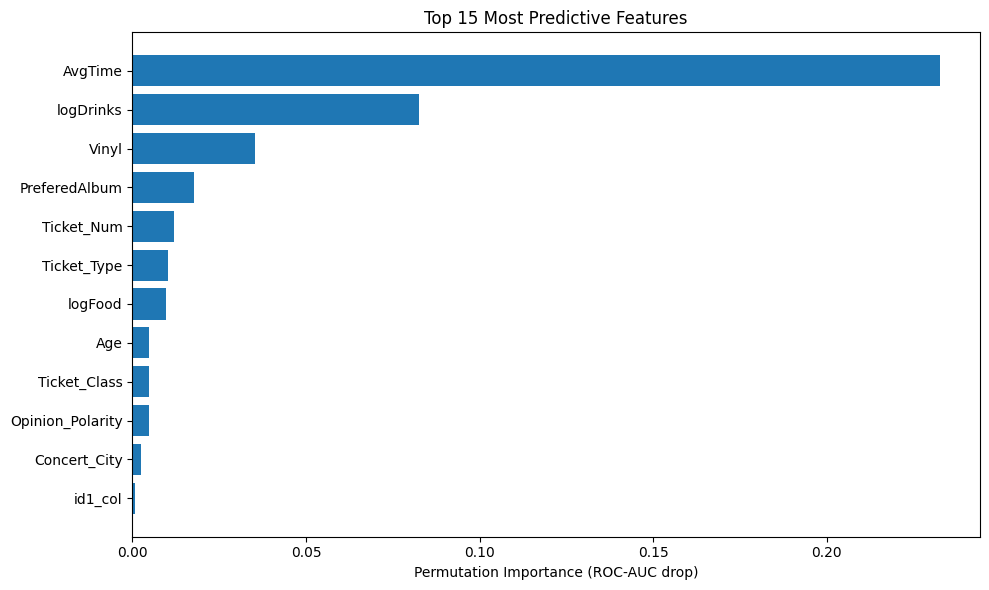

In [94]:
# Feature importance using permutation importance (more reliable than built-in)
print("Computing feature importances...")
perm_importance = permutation_importance(
    final_model, X_test_cat, Y_test_cat,  # Use held-out test set
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'
)

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': X_cat.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE RANKING:")
print("="*60)
print(importance_df.to_string(index=False))
print("="*60)

# Visualize top features
plt.figure(figsize=(10, 6))
top_n = 15
top_features = importance_df.head(top_n)
plt.barh(top_features['feature'], top_features['importance_mean'])
plt.xlabel('Permutation Importance (ROC-AUC drop)')
plt.title(f'Top {top_n} Most Predictive Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [105]:
output2= final_model.predict(X_test_ext)

# Get probabilities from the final model
output_proba = final_model.predict_proba(X_test_ext)[:, 1]

# Apply best threshold
output_pred_final = output_proba >= best_threshold

print(f"Predictions with threshold {best_threshold:.3f}:")
print(f"FreePass=1: {output_pred_final.sum()}, FreePass=0: {(~output_pred_final).sum()}")

output_df2 = (
    data_test_IDs
    .to_frame(name="Id")
    .assign(FreePass=output_pred_final.astype(bool))
)


output_df2.to_csv(os.getcwd()+"/results/gradboosttree-Alex_Peter-JAN31.csv", index=False)
output_df2.shape

Predictions with threshold 0.435:
FreePass=1: 1567, FreePass=0: 1287


(2854, 2)